Import necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import *
import io
from skimage.color import rgb2gray
from skimage import color
from skimage import io
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


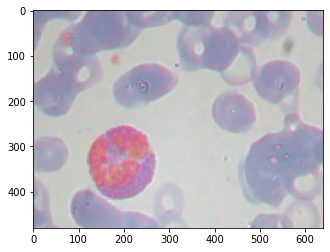

In [ ]:
#load image
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/BloodCells/dataset-master/dataset-master/JPEGImages/BloodImage_00036.jpg')
plt.imshow(img)

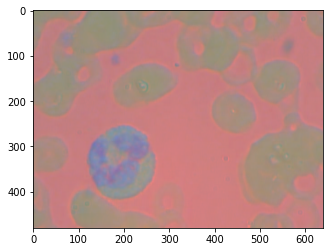

In [ ]:
imgYCC = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
plt.imshow(imgYCC)

In [ ]:
#Plotting Y,CB,CR,Components
imgY = imgYCC[:,:,0]
imgCb = imgYCC[:,:,1]
imgCr = imgYCC[:,:,2]

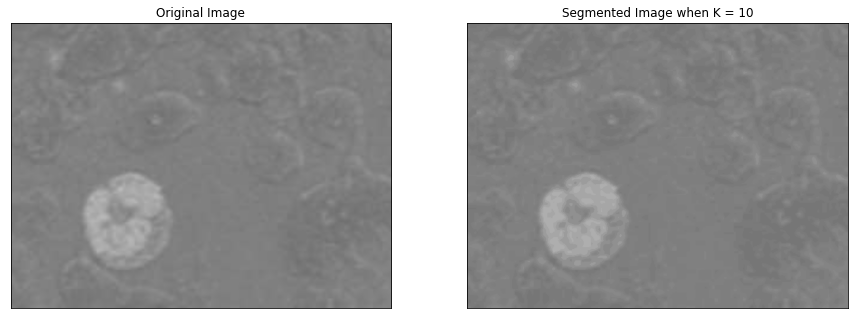

In [ ]:
img=cv2.cvtColor(imgCr,cv2.COLOR_RGB2BGR)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts=20
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

Watershed Segmentation techinique

Label: 11 Area: 286751
Label: 12 Area: 17750


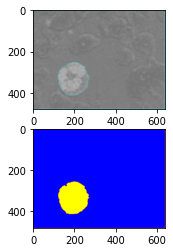

In [ ]:
import cv2
import csv
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

img = result_image
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 150, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#Check the total regions found before and after applying this. 

#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that we can use erode. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(opening,kernel,iterations=10)

# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

plt.subplot(2,1,1),plt.imshow(img)
plt.subplot(2,1,2),plt.imshow(img2)
#cv2.waitKey(0)


#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

Cell segmented using watershed transform